Author: Yini Rong

# Overview

This notebook is divided into four sections:

1. Exploratory data analysis
2. Text data preprocessing
3. Text vectorization
4. Classification models

In the Exploratory Data Analysis section, I will show the distribution of airline sentiments based on the reviews, the top reasons for negative reviews, the locations of the reviews, as well as common words associated with positive or negative sentiment. While the second and third section will show the preparation work on text data for model training, the last section will demonstrate performance evaluation among different models. Classification models are trained on both imbalanced data and balanced data.

Data source:  https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment

## TL;DR 
**Among the two types of text vectorization and three classification models, Support Vector Machine using TF-IDF vectorization results in the best AUC score of 0.888 in classifying the three classes: negative, neutral, and positive. It also have an accuracy score of 0.782. Logistic Regression using TF-IDF vectorization have very close AUC score of 0.885 but a higher accuracy score of 0.783. If it is more imperative to focus on negative reviews for the airline business, the Linear SVM using SGD training and TF-IDF vectorization is the best in achieving the highest recall score for the negative sentiment class.**

In [1]:
## Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

# Remove the limit for the number of displayed columns
pd.set_option("display.max_columns", None)

# Set the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

## Preprocessing libraries

# nltk
import nltk
nltk.download('stopwords')

import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# import wordcloud
import wordcloud
from wordcloud import STOPWORDS
from wordcloud import WordCloud

# For Model training
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC 

# Metrics for accuracy
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yinirong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Read in data
data = pd.read_csv('Tweets.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

# Exploratory data analysis

Out of the 14.5K reviews, approximately 60% of the reviews were negative. The negative reviews were close to 1.5 times the positive and neutral reviews combined. The top reason for negative review was related to customer service issues, consisting of 32% of all negative reviews. Another 30% of the negative reviews were due to either late or cancelled flights. 

The top 5 tweet locations for all reviews were New York City, Boston, Washington D.C., Chicago, and Los Angeles. These are busy airports with many domestic and international flights. Because of the higher volume of passengers coming through these locations, they were likely to have higher number of negative reviews.

From the word clouds, positive reviews are associated with certain words that are *not* with negative reviews and vice versa. For example, positive review word cloud shows "thank," "great," "awesome," and "love" whereas negative review word cloud shows "time," "hold," "hour," "help," and "bag." Recognizing specific words that highly associated with a particular sentiment could help a classification model better predict the sentiment of a new review. However, many words, such as "flight" and "customer service," were used across sentiments, hence reducing the clear demarcation across sentiment classes.

In [3]:
print("Percentage of null or na values:")
((data.isnull() | data.isna()).sum() * 100 / data.index.size).round(2)

Percentage of null or na values:


tweet_id                         0.00
airline_sentiment                0.00
airline_sentiment_confidence     0.00
negativereason                  37.31
negativereason_confidence       28.13
airline                          0.00
airline_sentiment_gold          99.73
name                             0.00
negativereason_gold             99.78
retweet_count                    0.00
text                             0.00
tweet_coord                     93.04
tweet_created                    0.00
tweet_location                  32.33
user_timezone                   32.92
dtype: float64

In [4]:
print(f"There are {data.duplicated().sum()} duplicate records in the datset.")

There are 36 duplicate records in the datset.


In [5]:
data.drop_duplicates(inplace = True)
print(f"There are {data.duplicated().sum()} duplicate records in the datset.")

There are 0 duplicate records in the datset.


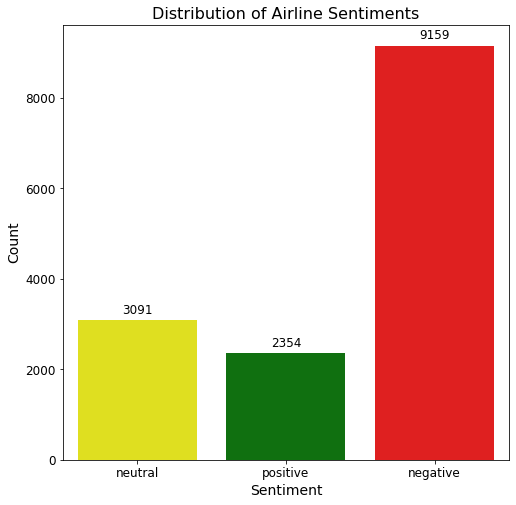

In [6]:
# Visualize sentiment category counts
plt.figure(figsize=(8, 8))
ax = sns.countplot(data=data,x='airline_sentiment',palette=['yellow', 'green','red'])
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Distribution of Airline Sentiments', fontsize=16)

# Add counts on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, xytext=(0, 10), textcoords='offset points')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

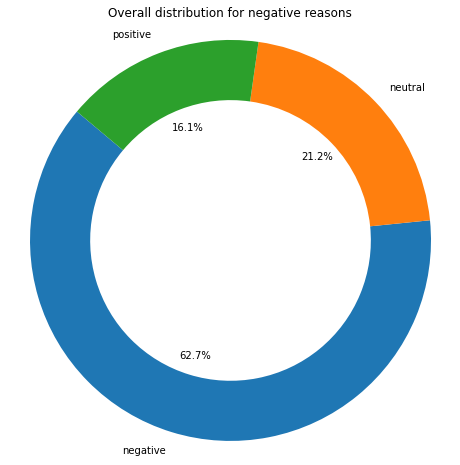

In [7]:
# Calculate the value counts for each negative reason
value_counts = data['airline_sentiment'].value_counts()

# Create a donut-like pie chart using matplotlib and seaborn
plt.figure(figsize=(8, 8))
labels = value_counts.index
values = value_counts.values
# colors = sns.color_palette('pastel')[0:len(labels)]  # Use pastel colors for the chart
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.3))
plt.title('Overall distribution for negative reasons')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is drawn as a circle.
plt.show()

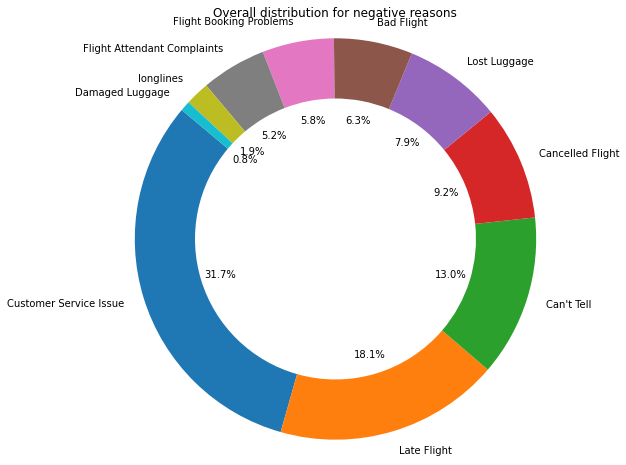

In [8]:
# Calculate the value counts for each negative reason
value_counts = data['negativereason'].value_counts()

# Create a donut-like pie chart using matplotlib and seaborn
plt.figure(figsize=(8, 8))
labels = value_counts.index
values = value_counts.values
# colors = sns.color_palette('pastel')[0:len(labels)]  # Use pastel colors for the chart
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.3))
plt.title('Overall distribution for negative reasons')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is drawn as a circle.
plt.show()

In [9]:
value_counts = pd.DataFrame(data.tweet_location.value_counts())
value_counts.describe()

,tweet_location
count,3081.000000
mean,3.207076
std,8.505306
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,157.000000


In [10]:
value_counts.loc[(value_counts.tweet_location>50)]

,tweet_location
"Boston, MA",157
"New York, NY",156
"Washington, DC",148
New York,127
USA,125
Chicago,104
New York City,96
"Los Angeles, CA",96
NYC,95
"San Francisco, CA",91


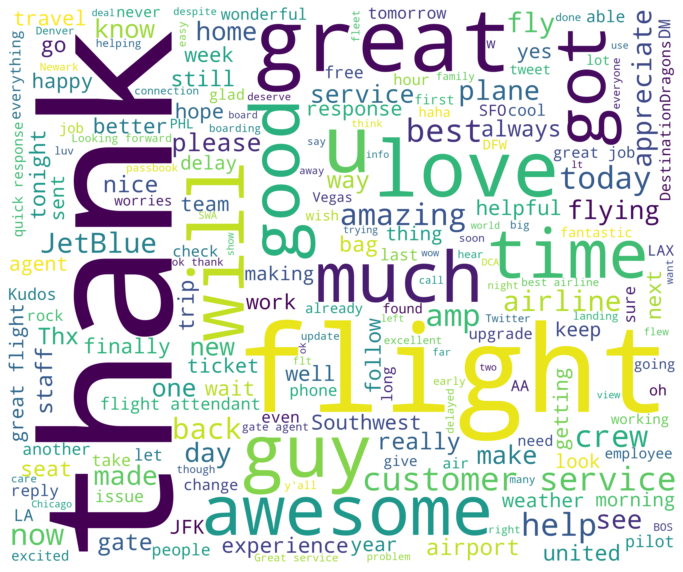

In [11]:
# Wordcloud for positive reasons

positive_reviews=data[data['airline_sentiment']=='positive']
words = ' '.join(positive_reviews['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word and not word.startswith('@') and word != 'RT'])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=3000,
                      height=2500).generate(cleaned_word)
plt.figure(1,figsize=(12, 12), facecolor = None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

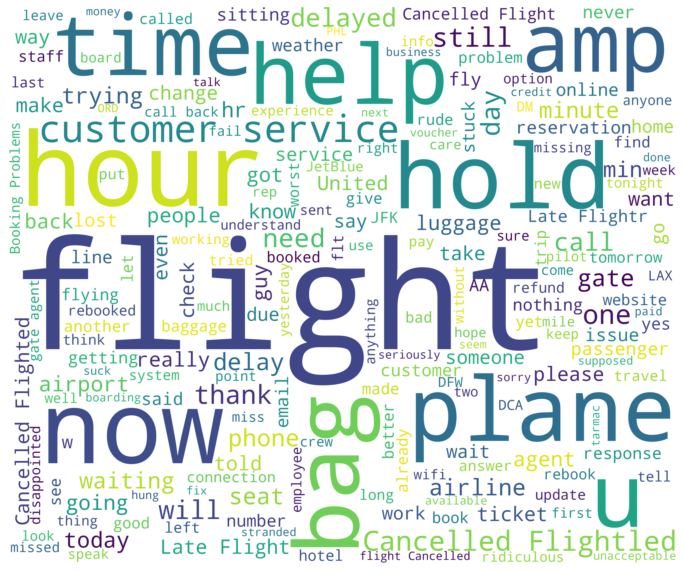

In [12]:
# Wordcloud for positive reasons

negative_reviews=data[data['airline_sentiment']=='negative']
words = ' '.join(negative_reviews['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word and not word.startswith('@') and word != 'RT'])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=3000,
                      height=2500).generate(cleaned_word)
plt.figure(1,figsize=(12, 12), facecolor = None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# Text data preprocessing

The review text was standardized to allow for better model performance. Standardization includes keeping only alpha-numeric words, converting to lower case, removing stopwords that convey no meaningful information, and applying a stemmer to reduce words to their root form.

In [13]:
mapping = {"negative": 0, 'neutral': 2, "positive": 1}
data["airline_sentiment"] = data["airline_sentiment"].map(mapping)

In [14]:
# Create a stemmer instance
stemmer = PorterStemmer()

# Modify the preprocess_text function to include stemming
def preprocess_text(text):
    # Remove special characters, URLs, and user mentions
    text = ' '.join(word for word in word_tokenize(text) if not word.startswith('@') and word.isalnum())
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    text = ' '.join(word for word in words if word not in stop_words)
    # Apply stemming to each word
    words = word_tokenize(text)
    text = ' '.join(stemmer.stem(word) for word in words)
    return text

data['text'] = data['text'].apply(preprocess_text)

In [15]:
data[['airline_sentiment', 'text']].head()

,airline_sentiment,text
0,2,virginamerica dhepburn said
1,1,virginamerica plu ad commerci experi tacki
2,2,virginamerica today must mean need take anoth ...
3,0,virginamerica realli aggress blast obnoxi ente...
4,0,virginamerica realli big bad thing


In [16]:
X=data["text"]
y=data["airline_sentiment"]

# Text vectorizations

Two types of text vectorization were used to train classification models. Both TF-IDF vectorizer and Counts vectorizer are common in transforming text into vector representations.

While a count vectorizer computes the frequency of each tokenized word in the entire corpus, it ignores the importance of the words. For example, a word could be indicative of a negative sentiment, but it did not appear frequenty in the reviews so its association with the negative sentiment might not be represented as strongly as a common word that appeared often in negative reviews.

TF-IDF vectorizer considers the importance of the word by highlighting words that are frequent in the current review text but not commonly found across the entire corpus, thereby giving more weight to the terms that are discriminative for that particular review text. As a result, it reduces the importance of common words.

However, both vectorizations are not the best in capturing the relationship and context between words.

In [17]:
tfidf_vectorizer = TfidfVectorizer(max_features=2000)

In [18]:
X_tfidf = tfidf_vectorizer.fit_transform(X)
print(len(tfidf_vectorizer.get_feature_names_out()))

2000


In [19]:
count_vectorizer = CountVectorizer(max_features=2000)
X_counts = count_vectorizer.fit_transform(X)
print(len(count_vectorizer.get_feature_names_out()))

2000


# Classification models

I trained 4 different models using `CountVectorizer` and `TfidfVectorizer` on the imbalanced (i.e., original) data as well as the balanced (i.e., resampled) data. The 4 classification models are the following:
1. Logistic Regression
2. Multinomial Naive Bayes
3. Support Vector Machine (SVM)
4. Linear SVM with stochastic gradient descent (SGD) training

## Model performance on imbalanced data
As mentioned above, the imbalanced data has much more negative reviews than both positive and neutral reviews combined. Many of the classification models results in accuracy scores of close to 0.78 and AUC scores of 0.88, but they vary in precision, recall, and F-1 score. From a business standpoint, airline companies may want to focus more on the negative reviews to better understand customer pain points. Therefore, overpredicting reviews to be negative can capture as many negative reviews as possible, increasing the recall score of the negative sentiment class. 

The SVM using TD-IDF vectorization results in the highest recall score of 0.98 for the negative sentiment class in exchange for fairly low recall scores for both positive and neutral sentiments since many positive and neutral sentiments are predicted to be negative. This aggressive prediction on negative reviews can result in noise when pinpointing key customer issues. Alternatively, the Linear SVM with SGD training and TD-IDF vectorization could be better at predicting the sentiment classes holistically while moderately skewing predictions towards the negative sentiment. It achieves a recall score of 0.94 and 0.65 for the negative and positive sentiment classes, respectively.

## Model performance on balanced data
The three classes were randomly resampled to have the same number of observations in the data. The data contains a little under 2,400 observations for each class, significantly reducing the original observation counts of the negative reviews. In terms of AUC scores, Logistic Regression with TF-IDF vectorization results in the highest at 0.885. In terms of recall score for the negative sentiment class, the Linear SVM with SGD training and TD-IDF vectorization continues to be the best in achieving 0.83 for the negative sentiment class without adding too much noise from the positive and neutral sentiment classes. A primary concern for the balanced data approach is the removal of negative reviews. By reducing the number of observations of negative reviews to match those of the other two sentiment classes, we lost information on certain customer issues, and our model may not be able to perform as well on a set of new reviews. A potential solution is to oversample the positive and neutral classes to match the higher number of observations of the negative classes instead.

In [20]:
# Training using three algorithms, let's see which will give us better result
model1 = LogisticRegression(random_state=50)
model2 = MultinomialNB()
model3 = SVC(probability=True, random_state=50)
model4 = SGDClassifier(loss='hinge', random_state=50)
models = [model1, model2, model3, model4]

In [21]:
def build_model(X, y, model):
    X = pd.DataFrame(X.toarray())
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=50)
    model.fit(X_train, y_train)
    
    # Evaluate the model
    train_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)
    
    # Predict probabilities for ROC AUC calculation
    # SGDClassifier with Linear SVM as loss function does not support predict_proba
    try:
        pr_train = model.predict_proba(X_train)
        pr_test = model.predict_proba(X_test)
        train_auc = roc_auc_score(y_train, pr_train, multi_class='ovo')
        test_auc = roc_auc_score(y_test, pr_test, multi_class='ovo')
    except AttributeError:
        train_auc = np.nan
        test_auc = np.nan
    
    # Predict labels for confusion matrix
    p_train = model.predict(X_train)
    p_test = model.predict(X_test)
    
    # Create a normalized confusion matrix
    cm_train = confusion_matrix(y_train, p_train, normalize='true')
    cm_test = confusion_matrix(y_test, p_test, normalize='true')
    
    # Create classification report
    report_train = classification_report(y_train, p_train)
    report_test = classification_report(y_test, p_test)
    
    return train_accuracy, test_accuracy, train_auc, test_auc, cm_train, cm_test, report_train, report_test

In [22]:
def create_cm_heatmap(cm):
    # Create a heatmap for the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    heatmap = sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', cbar=False,
                xticklabels=['Predicted Negative', 'Predicted Positive', 'Neutral'],
                yticklabels=['Actual Negative', 'Actual Positive', 'Neutral'])
    heatmap.xaxis.set_ticks_position('top')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix')
    plt.show()

## Use imbalanced data

M-O-D-E-L : <class 'sklearn.linear_model._logistic.LogisticRegression'> tfidf


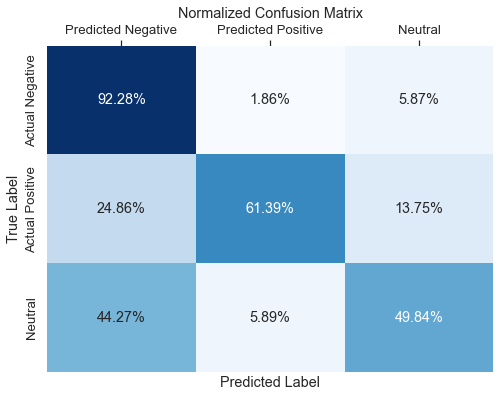

Accuracy score :  0.7832040164308535
AUC :  0.8854065409123183
Classification Report : 
               precision    recall  f1-score   support

           0       0.81      0.92      0.86      2745
           1       0.81      0.61      0.70       720
           2       0.64      0.50      0.56       917

    accuracy                           0.78      4382
   macro avg       0.75      0.68      0.71      4382
weighted avg       0.78      0.78      0.77      4382

-----------------------------------------------------------

M-O-D-E-L : <class 'sklearn.linear_model._logistic.LogisticRegression'> counts


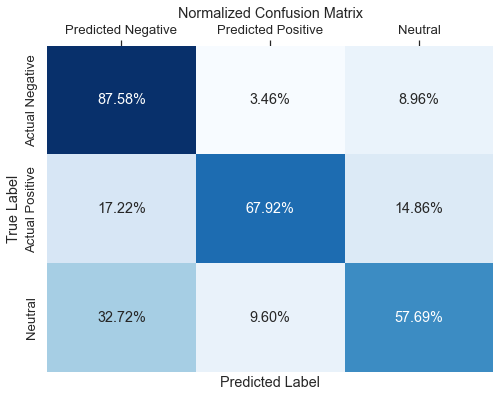

Accuracy score :  0.7809219534459151
AUC :  0.8834305461479262
Classification Report : 
               precision    recall  f1-score   support

           0       0.85      0.88      0.86      2745
           1       0.73      0.68      0.70       720
           2       0.60      0.58      0.59       917

    accuracy                           0.78      4382
   macro avg       0.73      0.71      0.72      4382
weighted avg       0.78      0.78      0.78      4382

-----------------------------------------------------------

M-O-D-E-L : <class 'sklearn.naive_bayes.MultinomialNB'> tfidf


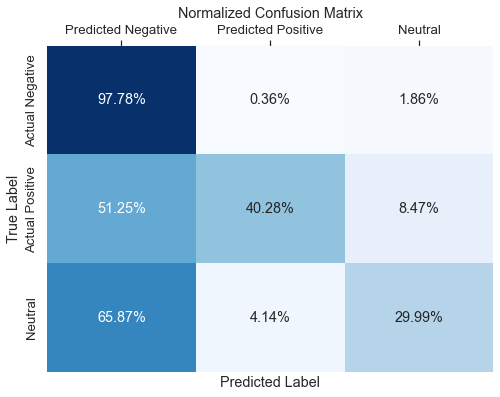

Accuracy score :  0.741442263806481
AUC :  0.8577938420177432
Classification Report : 
               precision    recall  f1-score   support

           0       0.73      0.98      0.84      2745
           1       0.86      0.40      0.55       720
           2       0.71      0.30      0.42       917

    accuracy                           0.74      4382
   macro avg       0.77      0.56      0.60      4382
weighted avg       0.75      0.74      0.70      4382

-----------------------------------------------------------

M-O-D-E-L : <class 'sklearn.naive_bayes.MultinomialNB'> counts


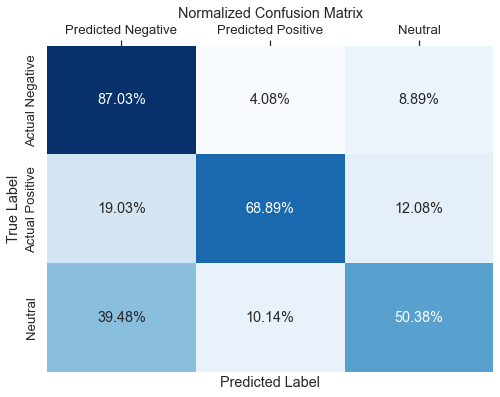

Accuracy score :  0.7638064810588773
AUC :  0.872859258608174
Classification Report : 
               precision    recall  f1-score   support

           0       0.83      0.87      0.85      2745
           1       0.71      0.69      0.70       720
           2       0.58      0.50      0.54       917

    accuracy                           0.76      4382
   macro avg       0.71      0.69      0.70      4382
weighted avg       0.76      0.76      0.76      4382

-----------------------------------------------------------

M-O-D-E-L : <class 'sklearn.svm._classes.SVC'> tfidf


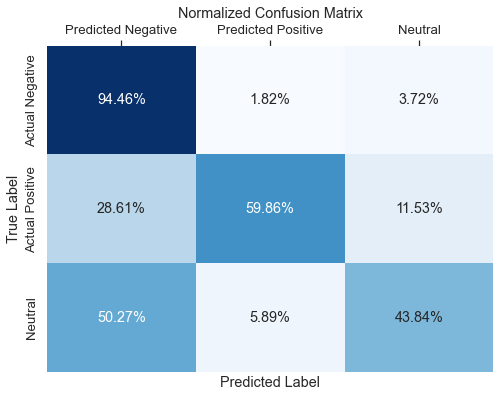

Accuracy score :  0.7818347786398905
AUC :  0.8881998106555943
Classification Report : 
               precision    recall  f1-score   support

           0       0.80      0.94      0.86      2745
           1       0.81      0.60      0.69       720
           2       0.68      0.44      0.53       917

    accuracy                           0.78      4382
   macro avg       0.76      0.66      0.70      4382
weighted avg       0.77      0.78      0.77      4382

-----------------------------------------------------------

M-O-D-E-L : <class 'sklearn.svm._classes.SVC'> counts


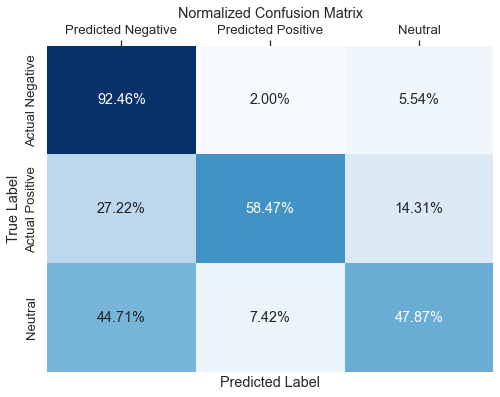

Accuracy score :  0.775445002282063
AUC :  0.8846706676772097
Classification Report : 
               precision    recall  f1-score   support

           0       0.81      0.92      0.86      2745
           1       0.77      0.58      0.67       720
           2       0.63      0.48      0.55       917

    accuracy                           0.78      4382
   macro avg       0.74      0.66      0.69      4382
weighted avg       0.77      0.78      0.76      4382

-----------------------------------------------------------

M-O-D-E-L : <class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'> tfidf


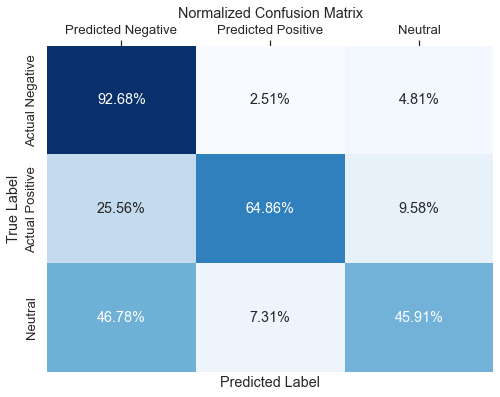

Accuracy score :  0.7832040164308535
AUC :  nan
Classification Report : 
               precision    recall  f1-score   support

           0       0.81      0.93      0.86      2745
           1       0.77      0.65      0.71       720
           2       0.68      0.46      0.55       917

    accuracy                           0.78      4382
   macro avg       0.75      0.68      0.71      4382
weighted avg       0.77      0.78      0.77      4382

-----------------------------------------------------------

M-O-D-E-L : <class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'> counts


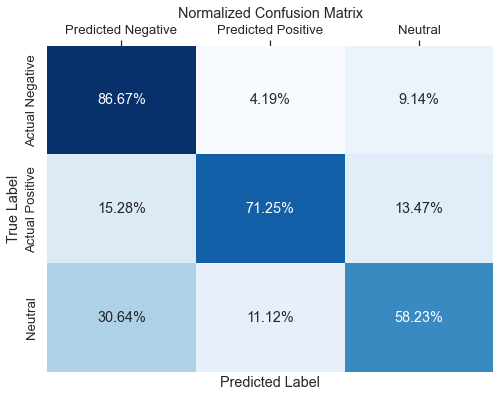

Accuracy score :  0.7818347786398905
AUC :  nan
Classification Report : 
               precision    recall  f1-score   support

           0       0.86      0.87      0.86      2745
           1       0.70      0.71      0.71       720
           2       0.61      0.58      0.59       917

    accuracy                           0.78      4382
   macro avg       0.72      0.72      0.72      4382
weighted avg       0.78      0.78      0.78      4382

-----------------------------------------------------------



In [23]:
vectorizers = ['tfidf', 'counts']

for model in models:
    i=0
    for X in [X_tfidf, X_counts]:
        
        print("M-O-D-E-L :", type(model), vectorizers[i])
        train_accuracy, test_accuracy, train_auc, test_auc, cm_train, cm_test, report_train, report_test = build_model(X, y, model)
        create_cm_heatmap(cm_test)
        
        print("Accuracy score : ", test_accuracy)
        print("AUC : ", test_auc)
        print("Classification Report : \n", report_test)
        print("-----------------------------------------------------------\n")
        
        i+=1

## Use balanced data

In [24]:
data['airline_sentiment'].value_counts()

0    9159
2    3091
1    2354
Name: airline_sentiment, dtype: int64

In [33]:
# Separate tweets
neg_data = data[data['airline_sentiment'] == 0] # negative
pos_data = data[data['airline_sentiment'] == 1] # positive
neu_data = data[data['airline_sentiment'] == 2] # neutral

# Sample an equal number of negative, positive, and neutral tweets
num_samples = min(len(neg_data), len(pos_data), len(neu_data))
print(num_samples)
neg_data = neg_data.sample(n=num_samples, random_state=42)
pos_data = pos_data.sample(n=num_samples, random_state=42)
neu_data = neu_data.sample(n=num_samples, random_state=42)

# Concatenate the negative, positive, and neutral sentiment tweets
balanced_data = pd.concat([neg_data, pos_data, neu_data])

# Shuffle the rows
balanced_data = balanced_data.sample(frac=1, random_state=42)

2354


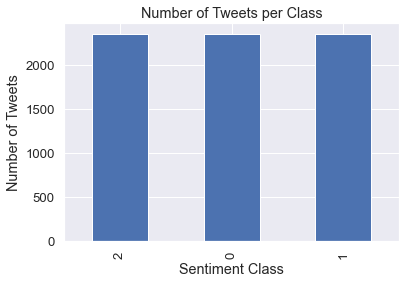

In [34]:
counts = balanced_data['airline_sentiment'].value_counts()
counts.plot(kind='bar')

plt.title('Number of Tweets per Class')
plt.xlabel('Sentiment Class')
plt.ylabel('Number of Tweets')
plt.show()

In [35]:
balanced_data['text'] = balanced_data['text'].apply(preprocess_text)

In [36]:
balanced_data[['airline_sentiment', 'text']].head()

,airline_sentiment,text
2841,2,unit old school ride home lax houston flyingre...
1841,0,unit read thread book 1st class seat 38e even ...
7053,2,jetblu delet tweet
12786,0,americanair would take long credit card compan...
8665,1,jetblu 4 min respon time impress offici truebl...


In [37]:
X=balanced_data["text"]
y=balanced_data["airline_sentiment"]

In [38]:
tfidf_vectorizer = TfidfVectorizer(max_features=2000)
X_tfidf = tfidf_vectorizer.fit_transform(X)
print(len(tfidf_vectorizer.get_feature_names_out()))

2000


In [39]:
count_vectorizer = CountVectorizer(max_features=2000)
X_counts = count_vectorizer.fit_transform(X)
print(len(count_vectorizer.get_feature_names_out()))

2000


M-O-D-E-L : <class 'sklearn.linear_model._logistic.LogisticRegression'> tfidf


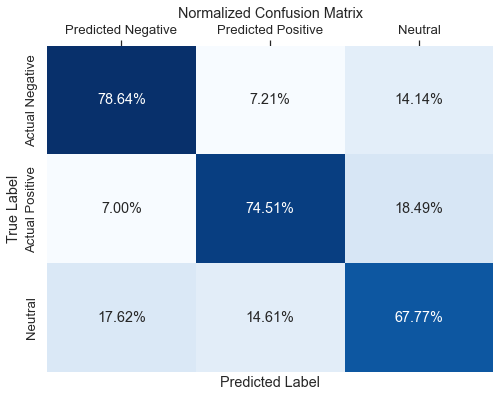

Accuracy score :  0.7366682397357244
AUC :  0.8816126316243729
Classification Report : 
               precision    recall  f1-score   support

           0       0.76      0.79      0.77       707
           1       0.78      0.75      0.76       714
           2       0.67      0.68      0.67       698

    accuracy                           0.74      2119
   macro avg       0.74      0.74      0.74      2119
weighted avg       0.74      0.74      0.74      2119

-----------------------------------------------------------

M-O-D-E-L : <class 'sklearn.linear_model._logistic.LogisticRegression'> counts


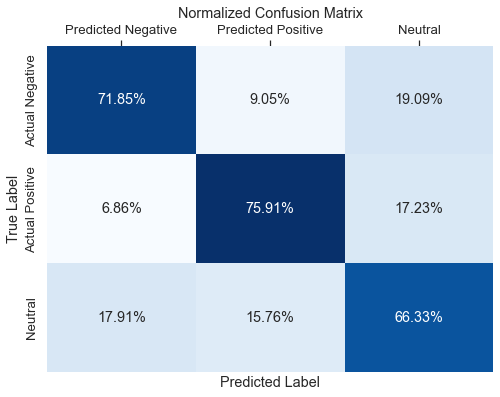

Accuracy score :  0.7140160453043889
AUC :  0.8720866546472958
Classification Report : 
               precision    recall  f1-score   support

           0       0.74      0.72      0.73       707
           1       0.76      0.76      0.76       714
           2       0.64      0.66      0.65       698

    accuracy                           0.71      2119
   macro avg       0.71      0.71      0.71      2119
weighted avg       0.72      0.71      0.71      2119

-----------------------------------------------------------

M-O-D-E-L : <class 'sklearn.naive_bayes.MultinomialNB'> tfidf


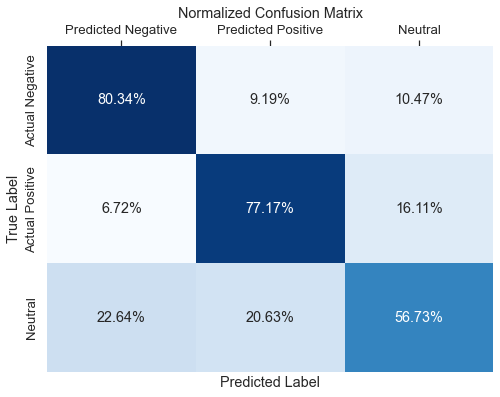

Accuracy score :  0.7149598867390279
AUC :  0.8659550962336953
Classification Report : 
               precision    recall  f1-score   support

           0       0.73      0.80      0.77       707
           1       0.72      0.77      0.75       714
           2       0.68      0.57      0.62       698

    accuracy                           0.71      2119
   macro avg       0.71      0.71      0.71      2119
weighted avg       0.71      0.71      0.71      2119

-----------------------------------------------------------

M-O-D-E-L : <class 'sklearn.naive_bayes.MultinomialNB'> counts


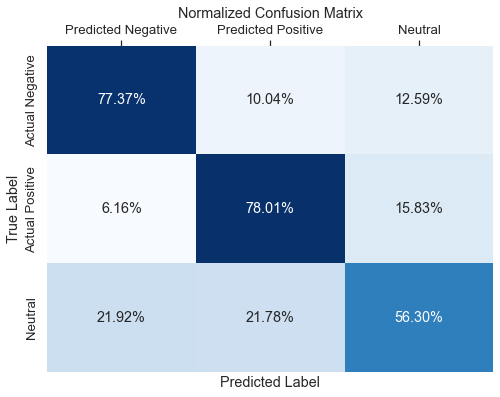

Accuracy score :  0.7064653138272771
AUC :  0.8699147015799898
Classification Report : 
               precision    recall  f1-score   support

           0       0.74      0.77      0.75       707
           1       0.71      0.78      0.75       714
           2       0.66      0.56      0.61       698

    accuracy                           0.71      2119
   macro avg       0.70      0.71      0.70      2119
weighted avg       0.70      0.71      0.70      2119

-----------------------------------------------------------

M-O-D-E-L : <class 'sklearn.svm._classes.SVC'> tfidf


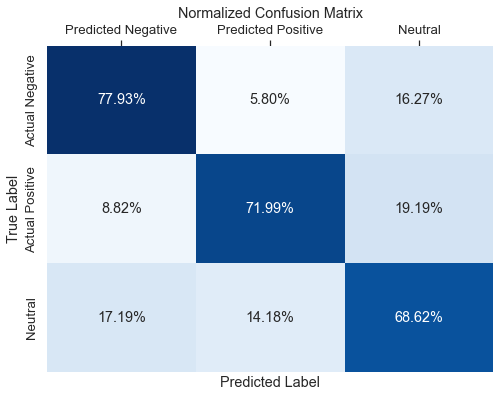

Accuracy score :  0.728645587541293
AUC :  0.8816395684584747
Classification Report : 
               precision    recall  f1-score   support

           0       0.75      0.78      0.76       707
           1       0.79      0.72      0.75       714
           2       0.66      0.69      0.67       698

    accuracy                           0.73      2119
   macro avg       0.73      0.73      0.73      2119
weighted avg       0.73      0.73      0.73      2119

-----------------------------------------------------------

M-O-D-E-L : <class 'sklearn.svm._classes.SVC'> counts


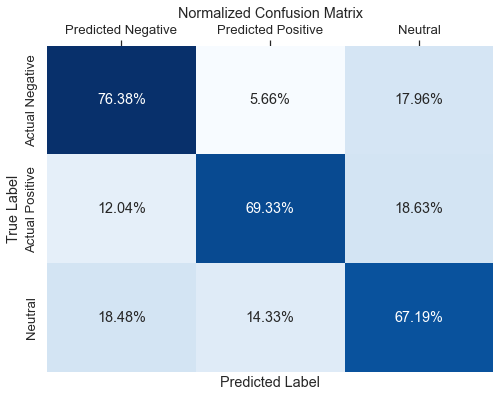

Accuracy score :  0.7097687588485134
AUC :  0.8692067690173841
Classification Report : 
               precision    recall  f1-score   support

           0       0.72      0.76      0.74       707
           1       0.78      0.69      0.73       714
           2       0.64      0.67      0.66       698

    accuracy                           0.71      2119
   macro avg       0.71      0.71      0.71      2119
weighted avg       0.71      0.71      0.71      2119

-----------------------------------------------------------

M-O-D-E-L : <class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'> tfidf


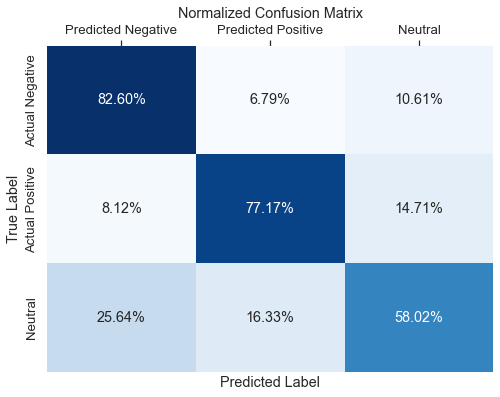

Accuracy score :  0.7267579046720151
AUC :  nan
Classification Report : 
               precision    recall  f1-score   support

           0       0.71      0.83      0.76       707
           1       0.77      0.77      0.77       714
           2       0.69      0.58      0.63       698

    accuracy                           0.73      2119
   macro avg       0.73      0.73      0.72      2119
weighted avg       0.73      0.73      0.72      2119

-----------------------------------------------------------

M-O-D-E-L : <class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'> counts


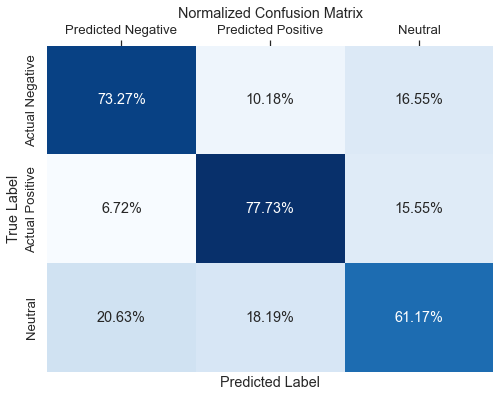

Accuracy score :  0.7078810759792354
AUC :  nan
Classification Report : 
               precision    recall  f1-score   support

           0       0.73      0.73      0.73       707
           1       0.74      0.78      0.76       714
           2       0.65      0.61      0.63       698

    accuracy                           0.71      2119
   macro avg       0.71      0.71      0.71      2119
weighted avg       0.71      0.71      0.71      2119

-----------------------------------------------------------



In [40]:
vectorizers = ['tfidf', 'counts']

for model in models:
    i=0
    for X in [X_tfidf, X_counts]:
        
        print("M-O-D-E-L :", type(model), vectorizers[i])
        train_accuracy, test_accuracy, train_auc, test_auc, cm_train, cm_test, report_train, report_test = build_model(X, y, model)
        create_cm_heatmap(cm_test)
        
        print("Accuracy score : ", test_accuracy)
        print("AUC : ", test_auc)
        print("Classification Report : \n", report_test)
        print("-----------------------------------------------------------\n")
        
        i+=1

# References

The Kaggle community has many existing analyses using this airline review dataset. I leveraged the following notebooks to aid my understanding in sentiment analysis:

- https://www.kaggle.com/code/ndsaotjk/airline-sentiment-a-beginner-s-guide
- https://www.kaggle.com/code/valeriamulina/twitter-sentiment-analysis
- https://www.kaggle.com/code/abuzarbhutta/sentimental-analysis-using-ml-lightgbm-and-bayes
- https://www.kaggle.com/code/zhikchen/understanding-naive-bayes-for-sentiment-analysis
- https://www.kaggle.com/code/sushilyeotiwad/tweets-sentiment-analysis-support-vector-machine
- https://www.kaggle.com/code/scodepy/airline-sentiment-analysis-using-bert